In [1]:
%matplotlib inline
import sys
import numpy as np
import os
import pickle
import h5py
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42 # allow for editable text in Illustrator
matplotlib.rcParams['ps.fonttype'] = 42  # allow for editable text in Illustrator
import seaborn as sb
import glob
import pandas as pd

In [2]:
basedir = '/cluster/work/grlab/projects/metagenome/data/gtex/'
basedir_meta = os.path.join(basedir, 'align_samples_extended_fast_')
basedir_star = os.path.join(basedir, 'alignments_star_small/results/alignments')
K = 41
files_meta = glob.glob(os.path.join(basedir_meta, 'realign.*.k%i.summary.txt' % K))
files_meta_map = glob.glob(os.path.join(basedir_meta, 'remap.*.k%i.summary.txt' % K))
files_star = glob.glob(os.path.join(basedir_star, '*.all.summary.txt'))
plotdir = os.path.join(basedir, 'plots', 'realignment_stats')
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

In [3]:
### collect metagraph alignments
samples_meta = []
all_counts_meta = []
for fname in files_meta:
    sample = os.path.basename(fname).split('.')[1]
    counts = np.zeros((77,), dtype='int')
    for line in open(fname, 'r'):
        sl = line.strip().split('\t')
        counts[int(sl[0])] = int(sl[1])
    samples_meta.append(sample)
    all_counts_meta.append(counts)
samples_meta_map = []
all_counts_meta_map = []
for fname in files_meta_map:
    sample = os.path.basename(fname).split('.')[1]
    counts = np.zeros((77,), dtype='int')
    for line in open(fname, 'r'):
        sl = line.strip().split('\t')
        counts[int(sl[0])] = int(sl[1])
    samples_meta_map.append(sample)
    all_counts_meta_map.append(counts)
### collect star alignments
samples_star = []
all_counts_star = []
for fname in files_star:
    sample = os.path.basename(fname).split('.')[0]
    counts = np.zeros((77,), dtype='int')
    for line in open(fname, 'r'):
        sl = line.strip().split('\t')
        counts[int(sl[0])] = int(sl[1])
    samples_star.append(sample)
    all_counts_star.append(counts)

In [5]:
df = dict()
df['meta_align'] = pd.DataFrame(np.array(all_counts_meta), index=np.array(samples_meta))
#df['meta_align'] = df['meta_align'].assign(tmp=df['meta_align'].sum(1)).sort_values('tmp', ascending=False).drop('tmp',1)
df['meta_align'] = df['meta_align'].sort_index()
df['meta_map'] = pd.DataFrame(np.array(all_counts_meta_map), index=np.array(samples_meta_map))
#df['meta_map'] = df['meta_map'].assign(tmp=df['meta_map'].sum(1)).sort_values('tmp', ascending=False).drop('tmp',1)
df['meta_map'] = df['meta_map'].sort_index()
df['star'] = pd.DataFrame(np.array(all_counts_star), index=np.array(samples_star))
#df['star'] = df['star'].assign(tmp=df['star'].sum(1)).sort_values('tmp', ascending=False).drop('tmp',1)
#df['star'] = df['star'].loc[df['meta_align'].index] ### account for some samples still missing for MetaGraph
df['star'] = df['star'].sort_index()

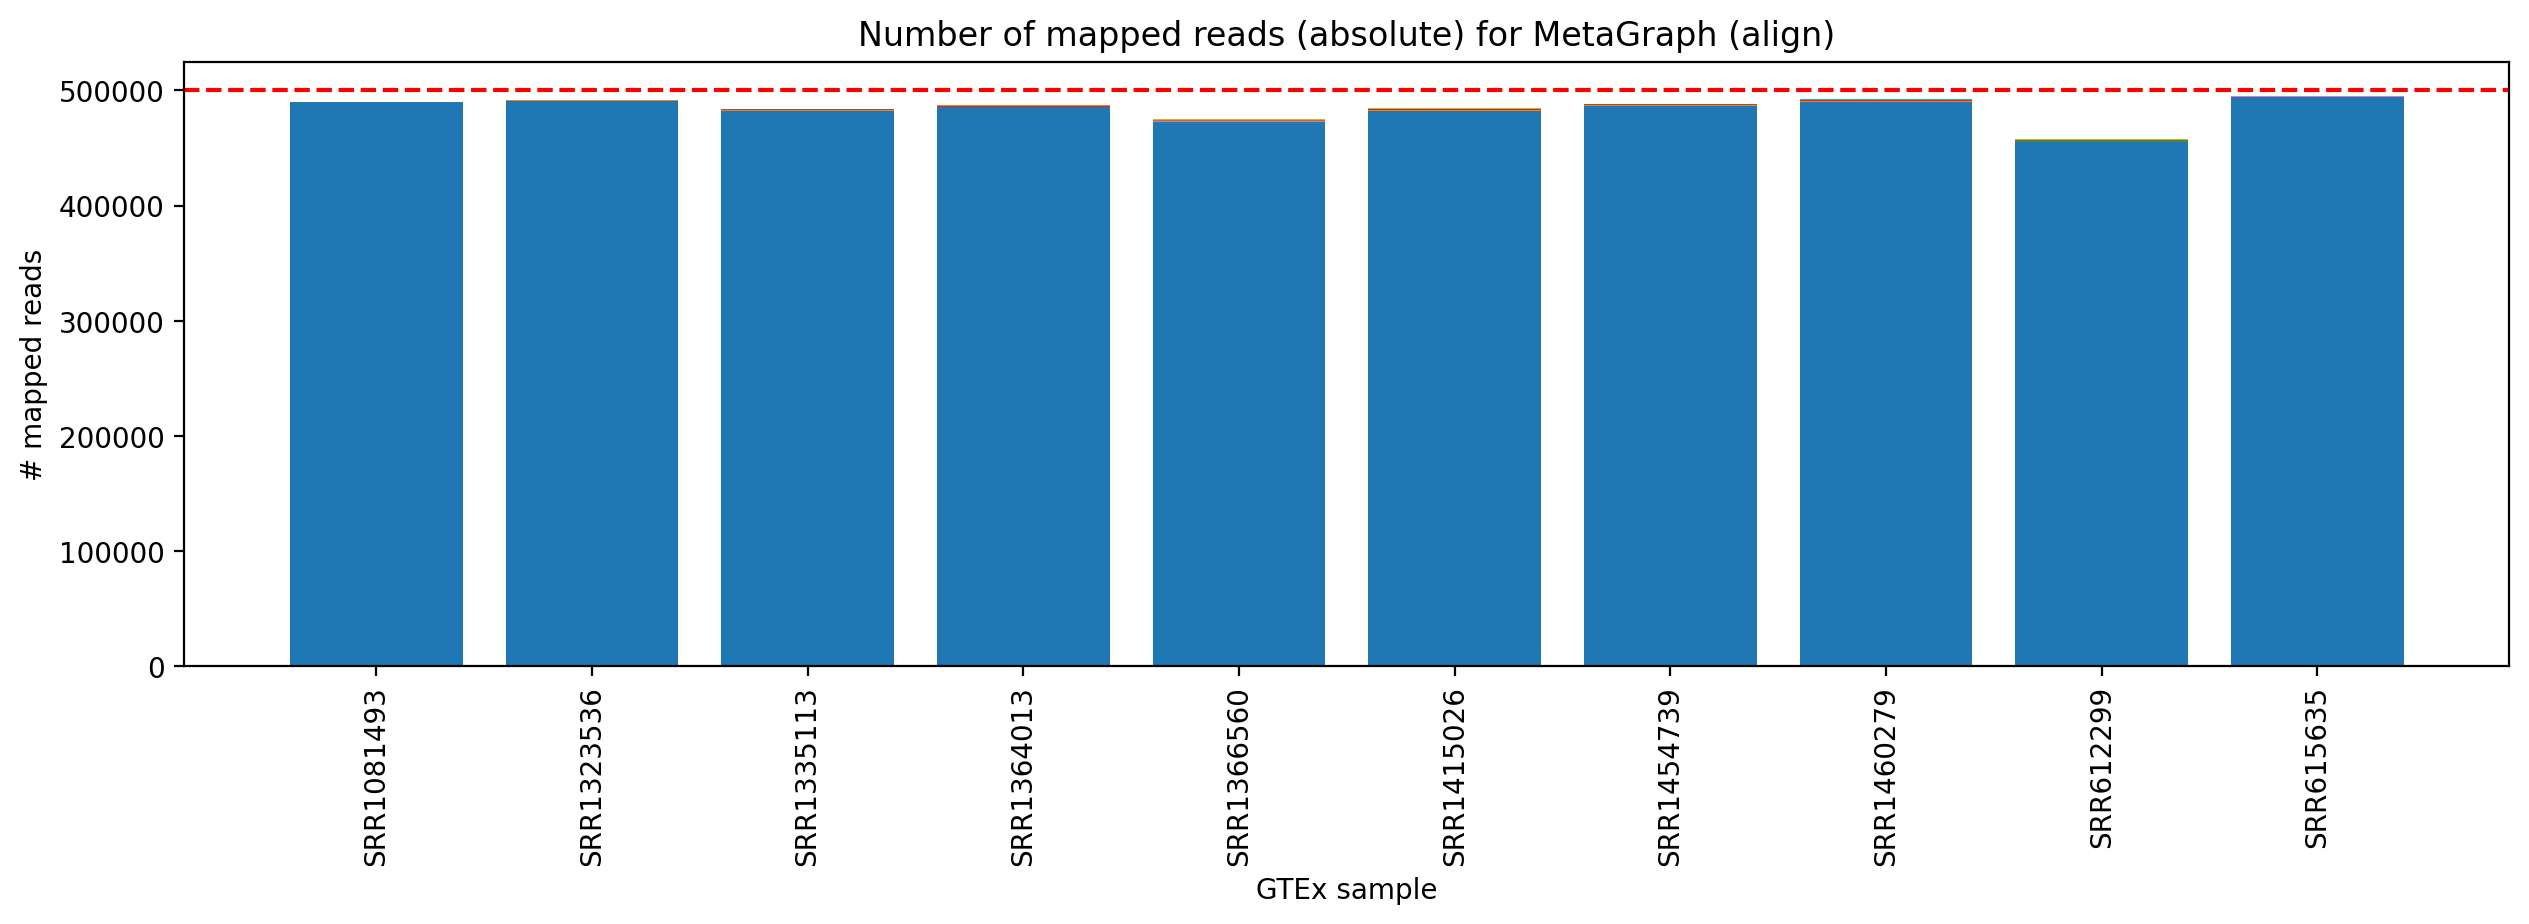

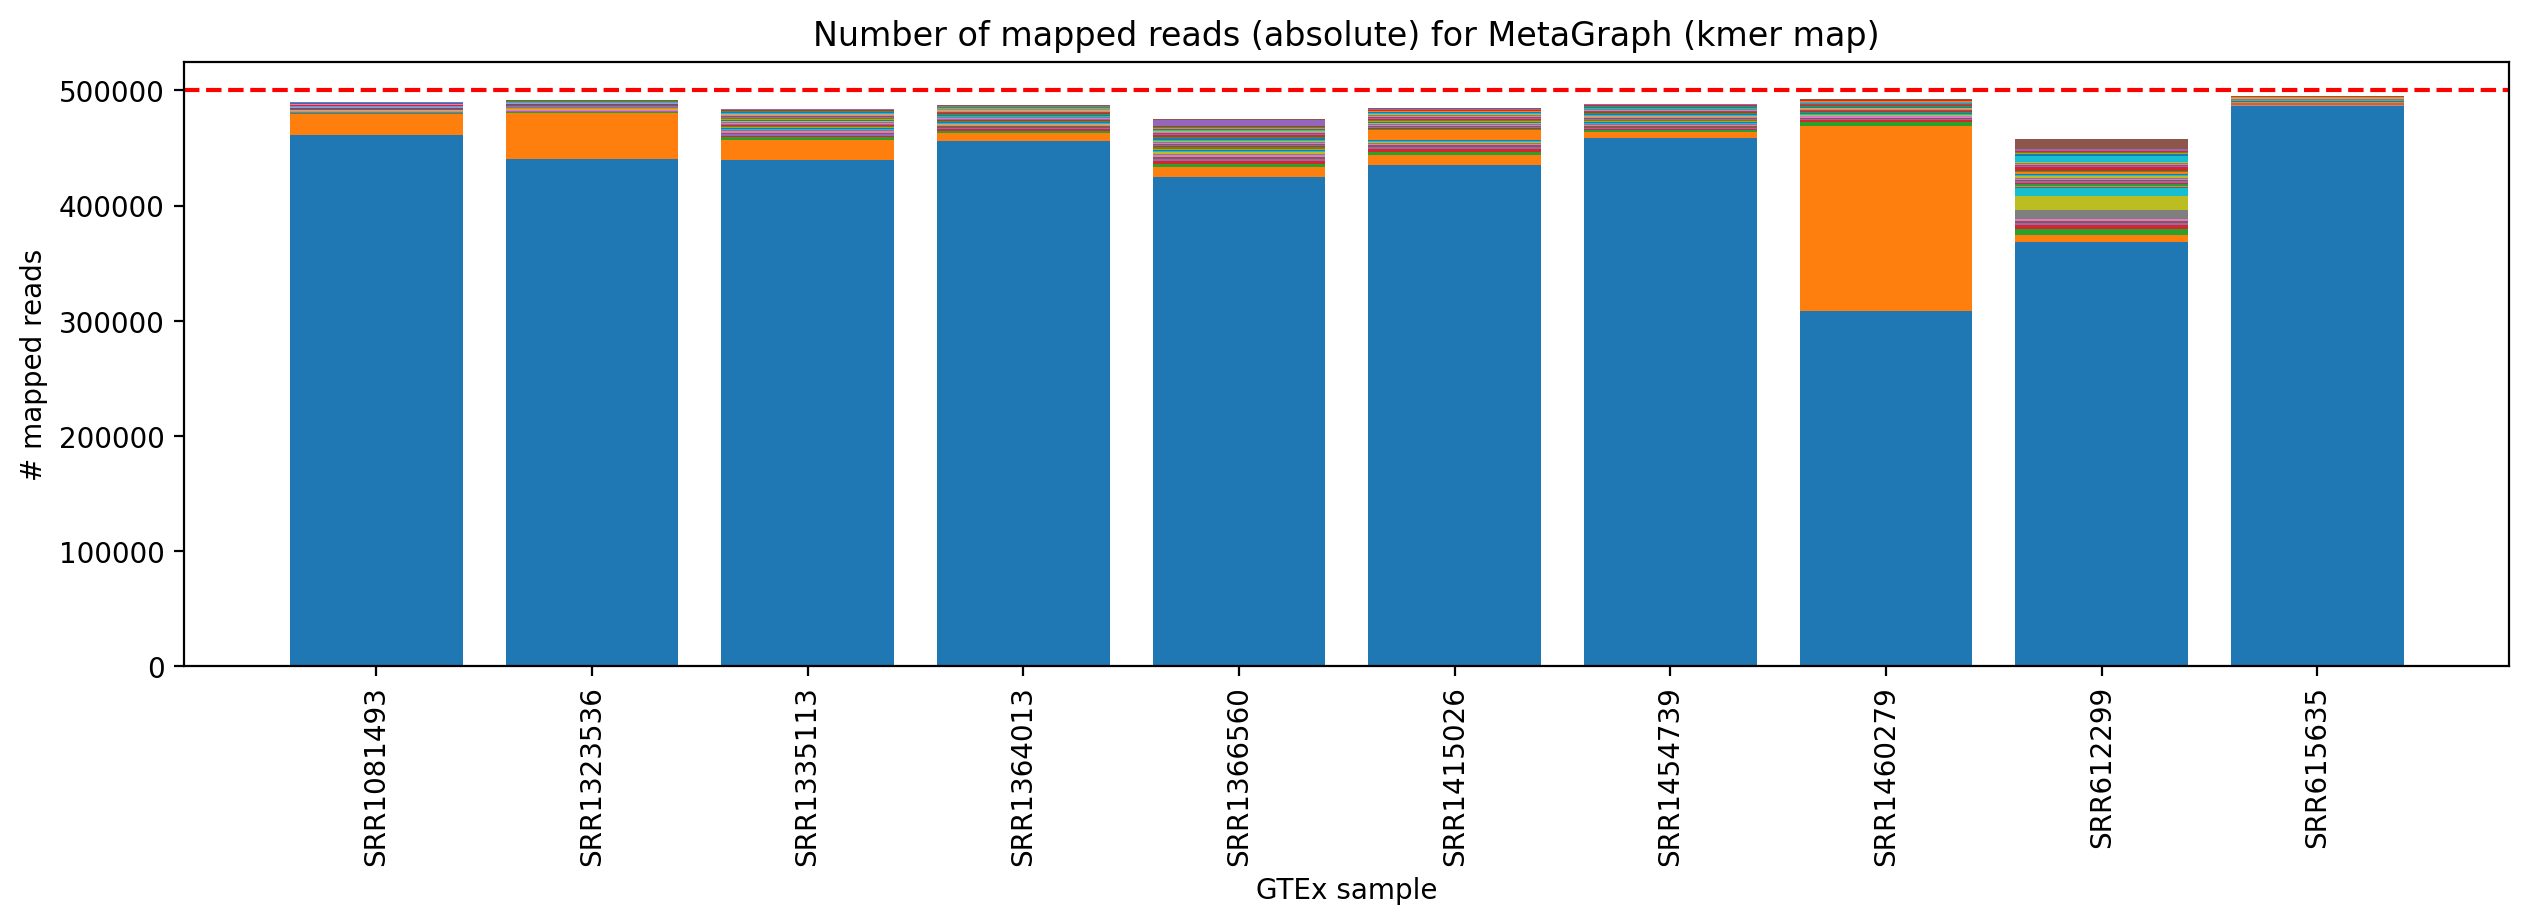

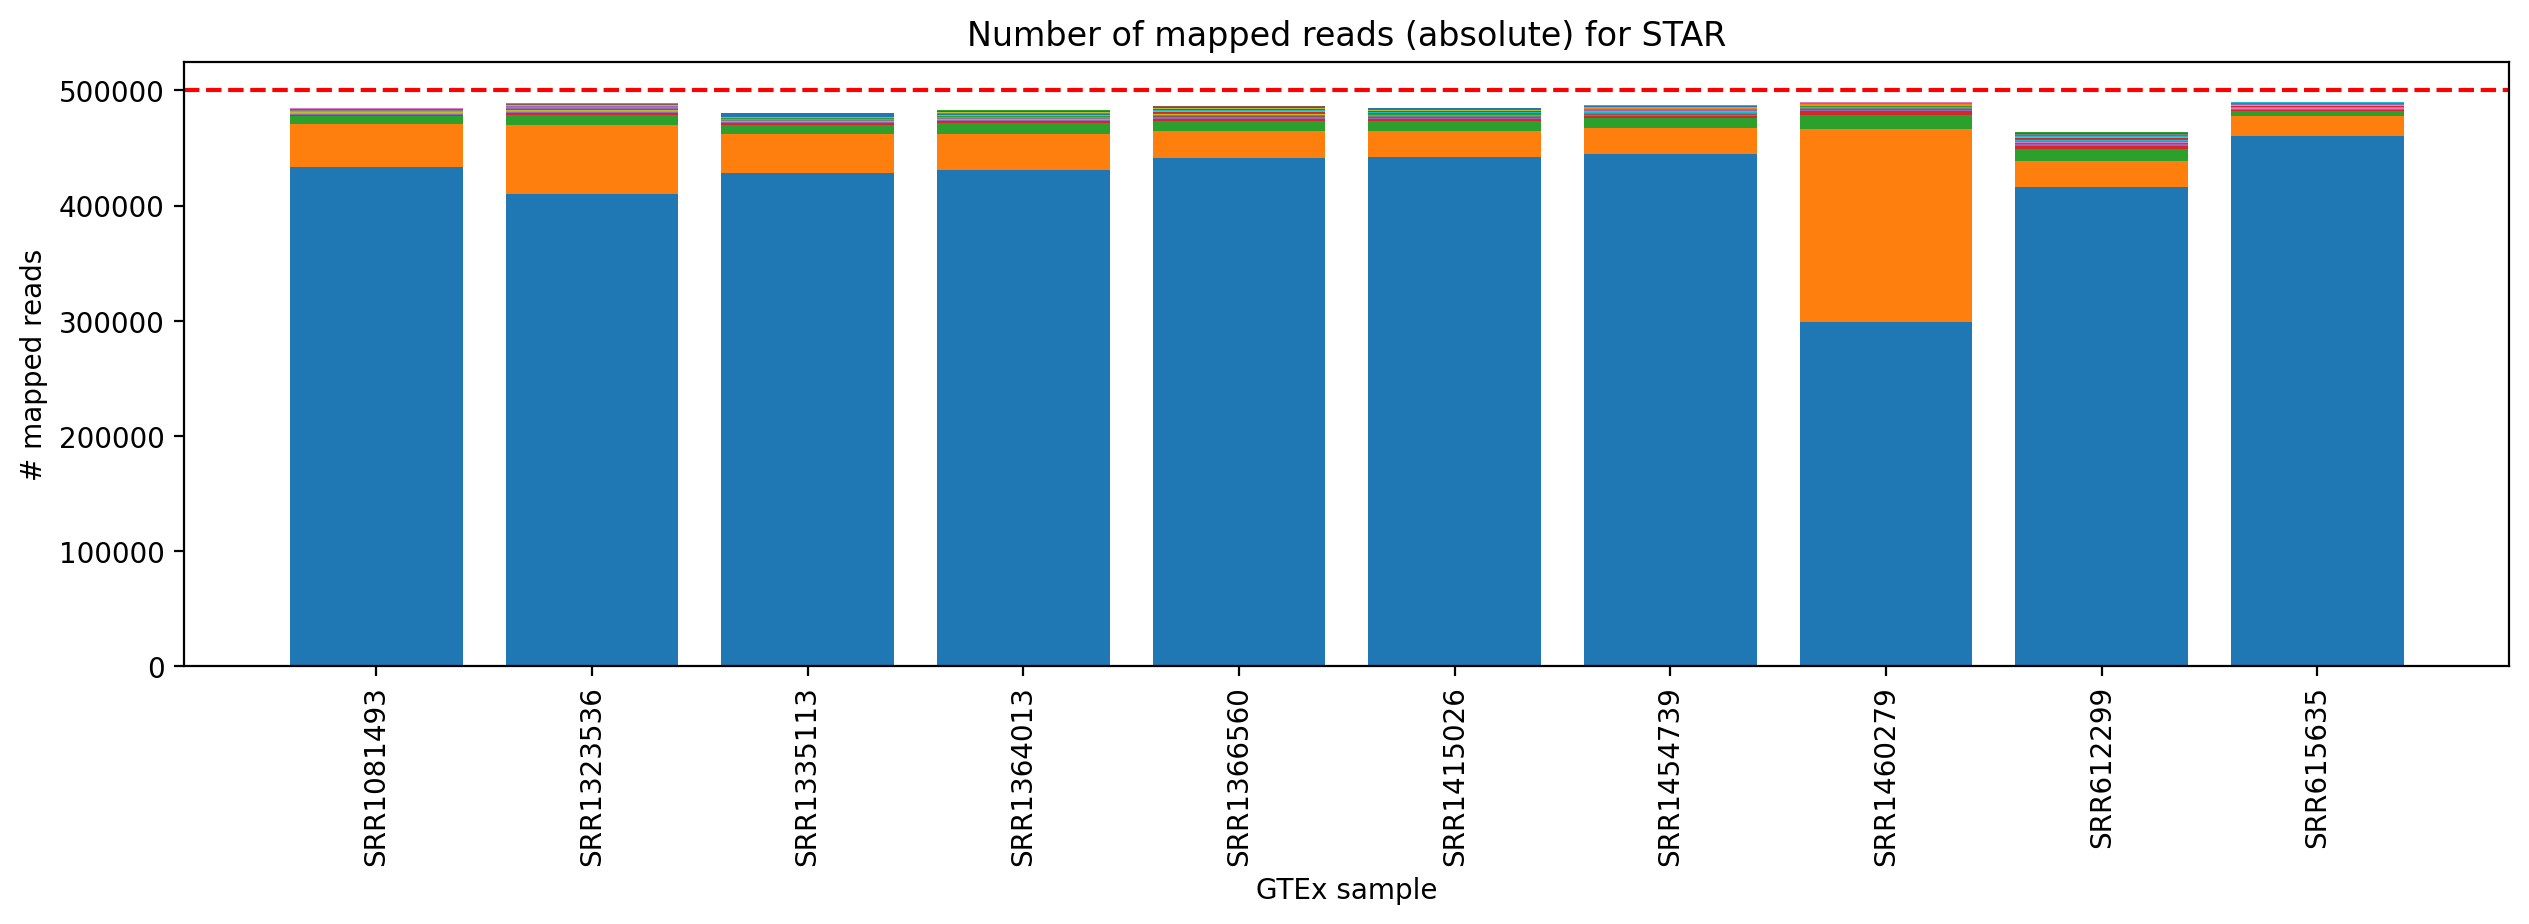

In [6]:
method = {'meta_align':'MetaGraph (align)', 'meta_map':'MetaGraph (kmer map)', 'star':'STAR'}
for key in ['meta_align', 'meta_map', 'star']:
    fig = plt.figure(figsize=(15, 4), dpi=200)
    ax = fig.add_subplot(111)
    for i in df[key].columns[:76]:
        if i == 0:
            ax.bar(np.arange(df[key].shape[0]), df[key].iloc[:, i]) # color='b', alpha=0.8)
            cum_sum = df[key].iloc[:, i].copy()
        else:
            ax.bar(np.arange(df[key].shape[0]), df[key].iloc[:, i], bottom=cum_sum) #, color='b', alpha=0.8 - (i / 150.0))
            cum_sum += df[key].iloc[:, i]
    ax.set_xticks(np.arange(df[key].shape[0]))
    ax.set_xticklabels(df[key].index, rotation=90)
    ax.set_ylabel('# mapped reads')
    ax.set_xlabel('GTEx sample')
    xlim = ax.get_xlim()
    ax.plot(xlim, [500000, 500000], 'r--')
    ax.set_xlim(xlim)
    #ax.plot(sp.arange(df[key].shape[0]), cum_sum + df[key].iloc[:, 76], 'r*')
    ax.set_title('Number of mapped reads (absolute) for %s' % method[key])
plt.savefig(os.path.join(plotdir, 'realigned_absolute.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(plotdir, 'realigned_absolute.pdf'), format='pdf', bbox_inches='tight')

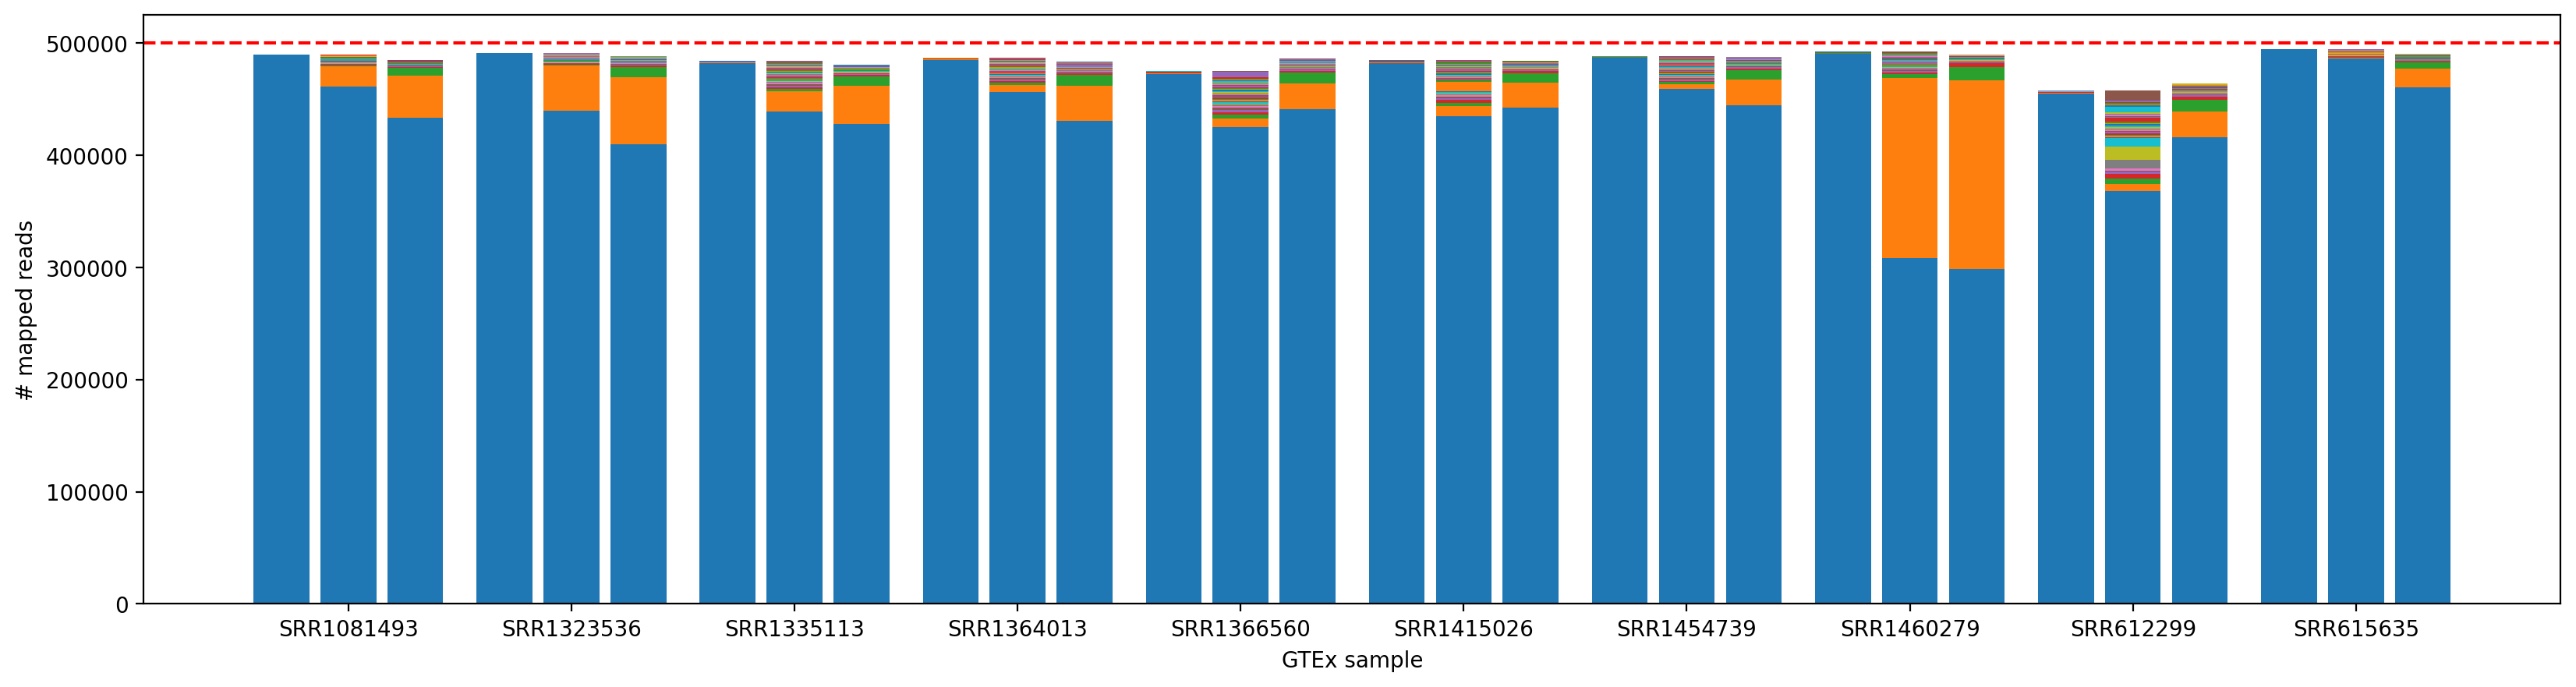

In [7]:
method = {'meta_align':'MetaGraph (align)', 'meta_map':'MetaGraph (kmer map)', 'star':'STAR'}
fig = plt.figure(figsize=(20, 5), dpi=200)
ax = fig.add_subplot(111)
for c, key in enumerate(['meta_align', 'meta_map', 'star']):
    plt.gca().set_prop_cycle(None)
    for i in df[key].columns[:76]:
        if i == 0:
            ax.bar(np.arange(df[key].shape[0]) + (c*0.3), df[key].iloc[:, i], width=0.25) # color='b', alpha=0.8)
            cum_sum = df[key].iloc[:, i].copy()
        else:
            ax.bar(np.arange(df[key].shape[0]) + (c*0.3), df[key].iloc[:, i], bottom=cum_sum, width=0.25) #, color='b', alpha=0.8 - (i / 150.0))
            cum_sum += df[key].iloc[:, i]
    ax.set_xticks(np.arange(df[key].shape[0]) + 0.3)
    ax.set_xticklabels(df[key].index)#, rotation=90)
    ax.set_ylabel('# mapped reads')
    ax.set_xlabel('GTEx sample')
xlim = ax.get_xlim()
ax.plot(xlim, [500000, 500000], 'r--')
ax.set_xlim(xlim)
#ax.set_title('Number of mapped reads (absolute) for %s' % method[key])
plt.savefig(os.path.join(plotdir, 'realigned_absolute_grouped.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(plotdir, 'realigned_absolute_grouped.pdf'), format='pdf', bbox_inches='tight')

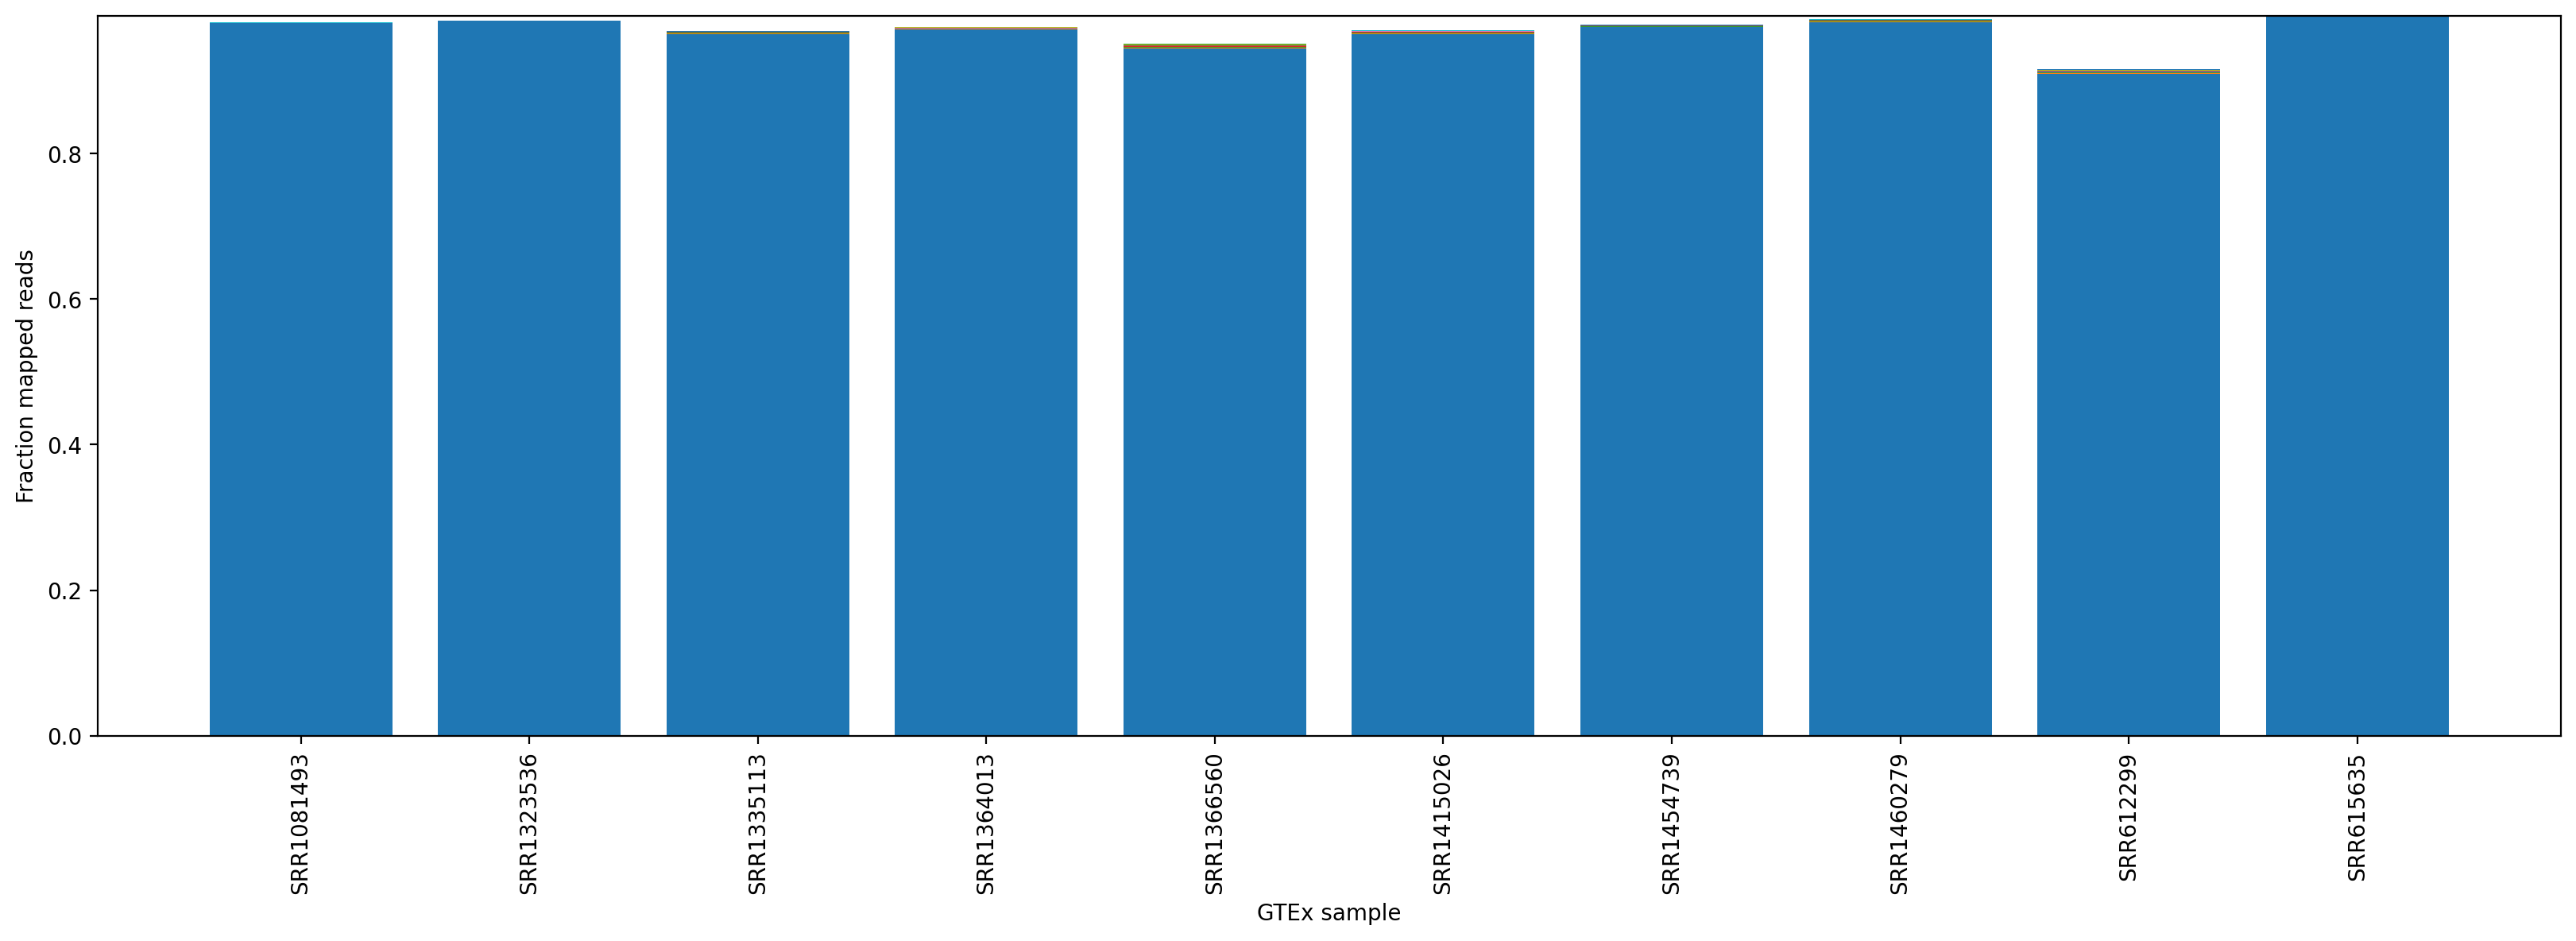

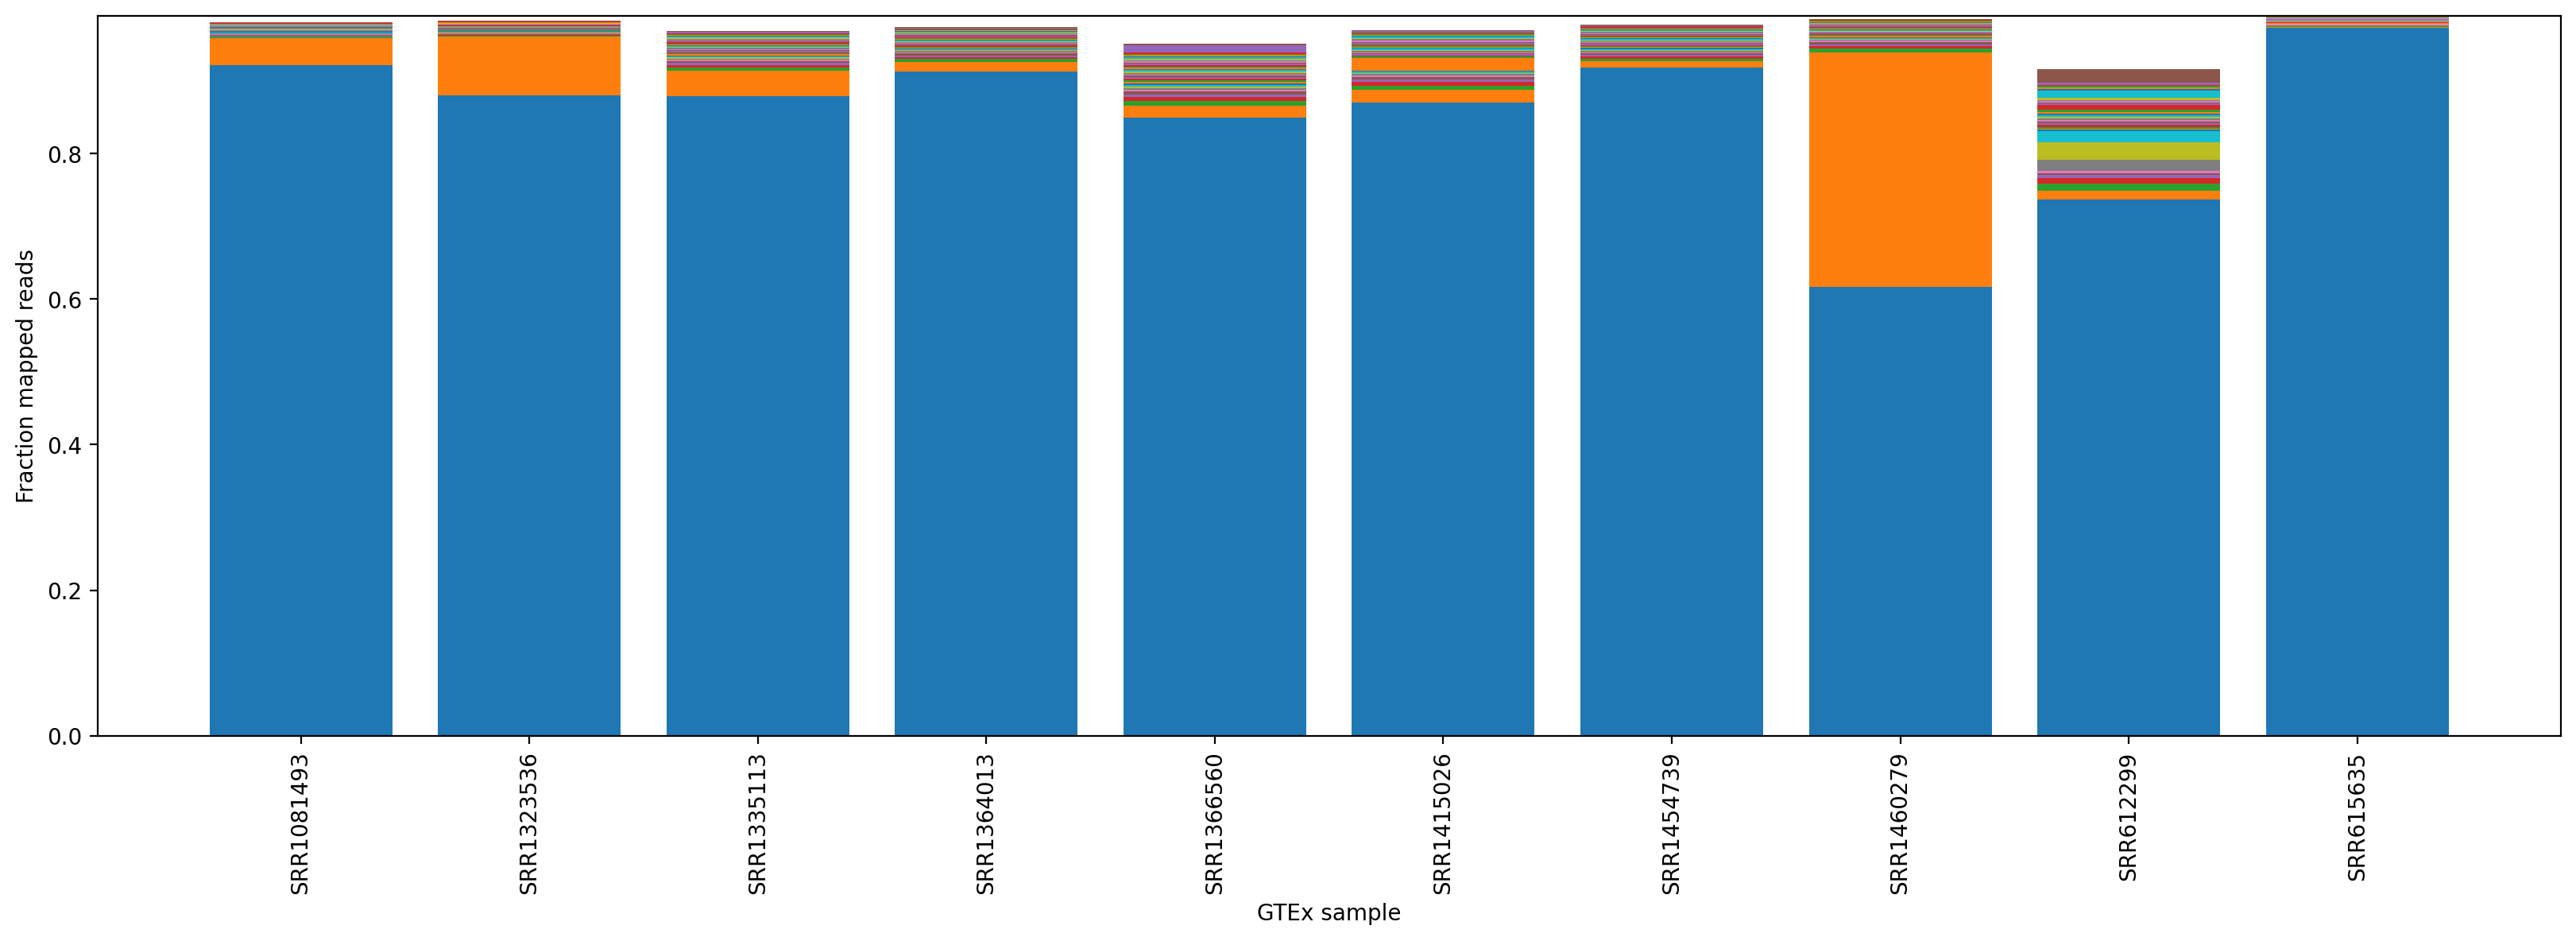

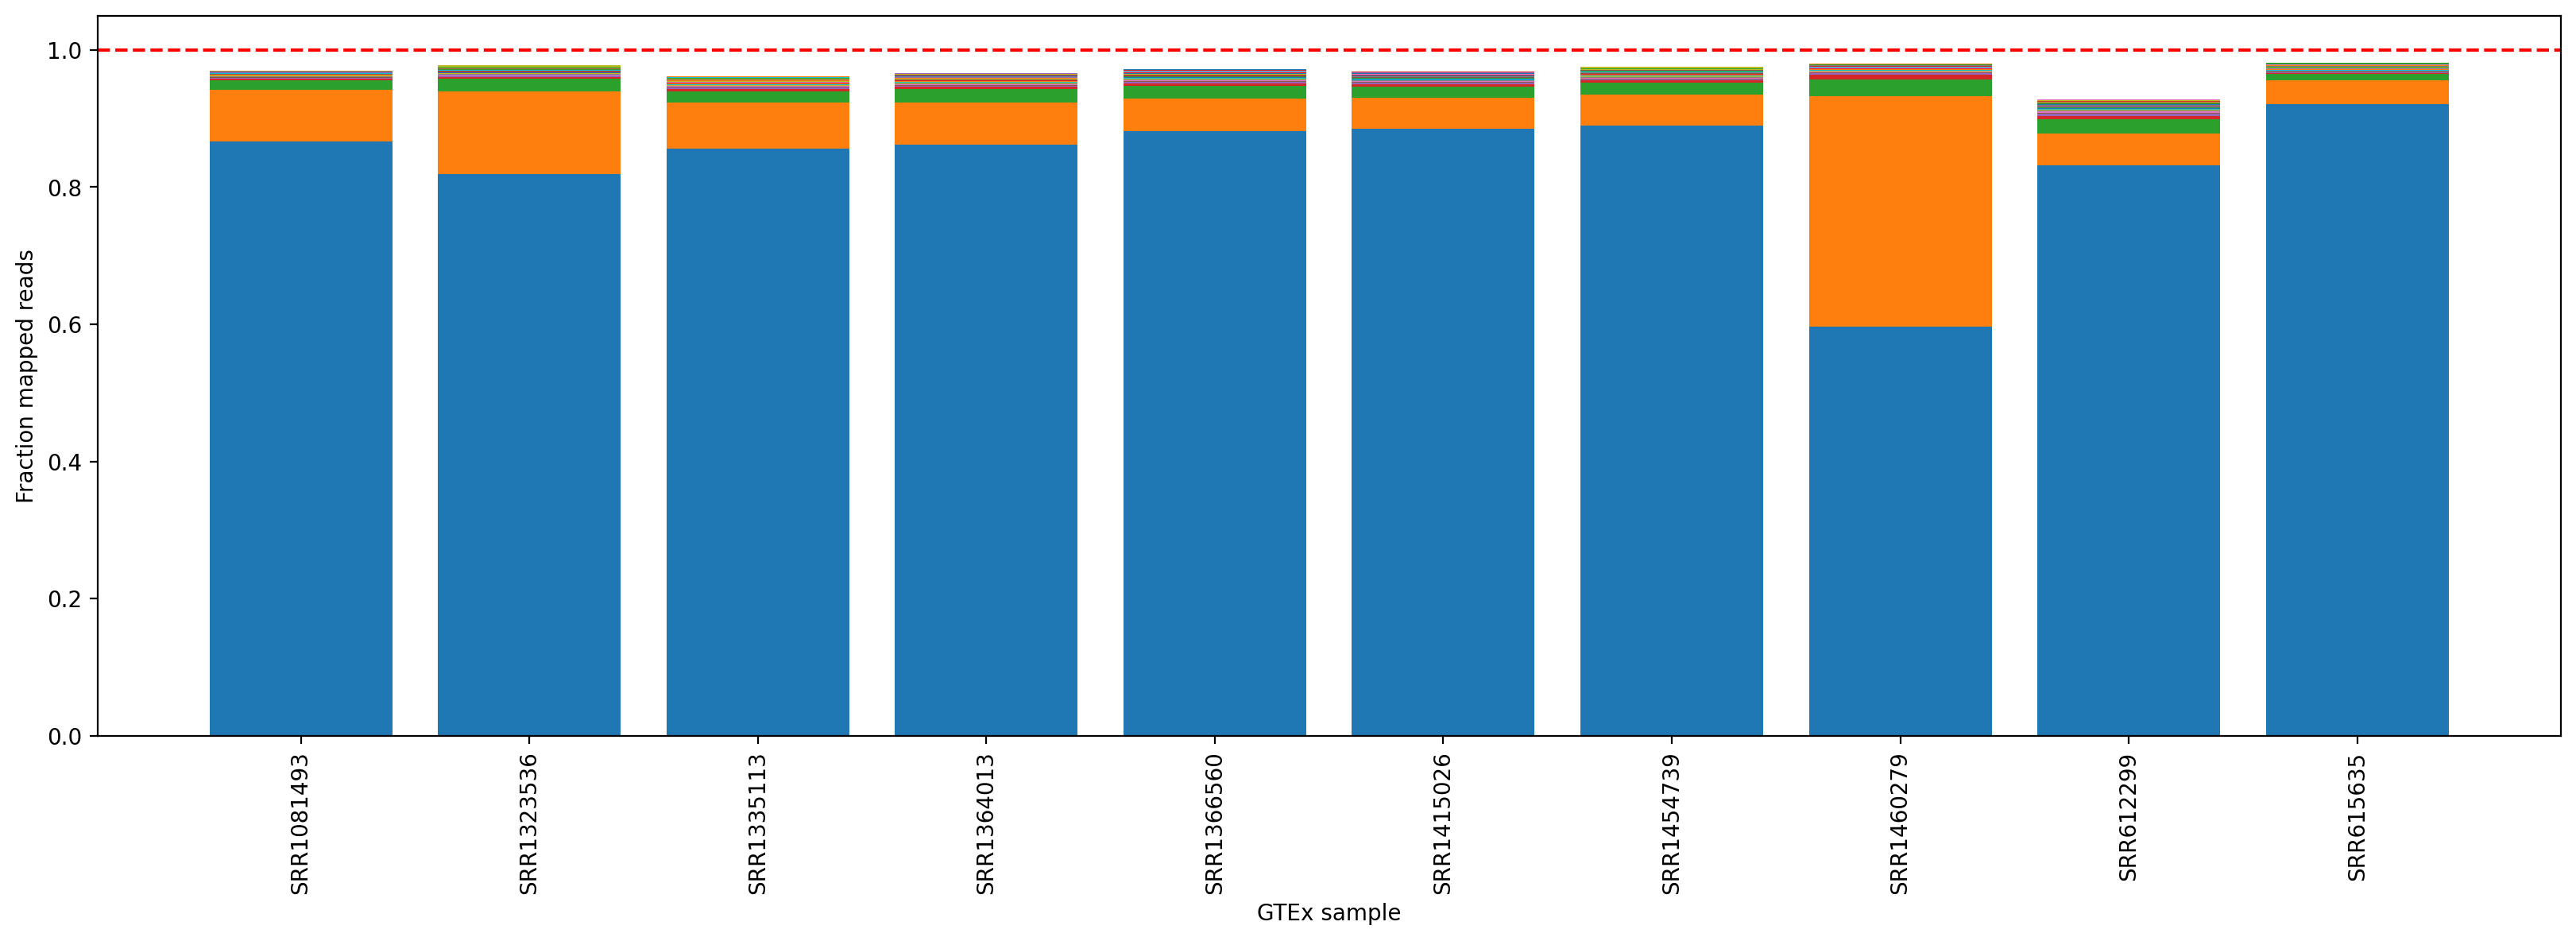

In [8]:
method = {'meta_align':'MetaGraph (align)', 'meta_map':'MetaGraph (kmer map)', 'star':'STAR'}
for key in ['meta_align', 'meta_map','star']:
    total = df[key].sum(1)
    fig = plt.figure(figsize=(20, 6), dpi=200)
    ax = fig.add_subplot(111)
    for i in df[key].columns[:76]:
        if i == 0:
            ax.bar(np.arange(df[key].shape[0]), df[key].iloc[:, i] / total) # color='b', alpha=0.8)
            cum_sum = (df[key].iloc[:, i] / total)
        else:
            ax.bar(np.arange(df[key].shape[0]), df[key].iloc[:, i] / total, bottom=cum_sum) #, color='b', alpha=0.8 - (i / 150.0))
            cum_sum += (df[key].iloc[:, i] / total)
    ax.set_xticks(np.arange(df[key].shape[0]))
    ax.set_xticklabels(df[key].index, rotation=90)
    ax.set_ylabel('Fraction mapped reads')
    ax.set_xlabel('GTEx sample')
xlim = ax.get_xlim()
ax.plot(xlim, [1, 1], 'r--')
ax.set_xlim(xlim)
plt.savefig(os.path.join(plotdir, 'realigned_relative.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(plotdir, 'realigned_relative.pdf'), format='pdf', bbox_inches='tight')
    #ax.plot(sp.arange(df[key].shape[0]), cum_sum + (df[key].iloc[:, 76] / total), 'r*')
    #ax.set_title('Number of mapped reads (relative) for %s' % method[key])

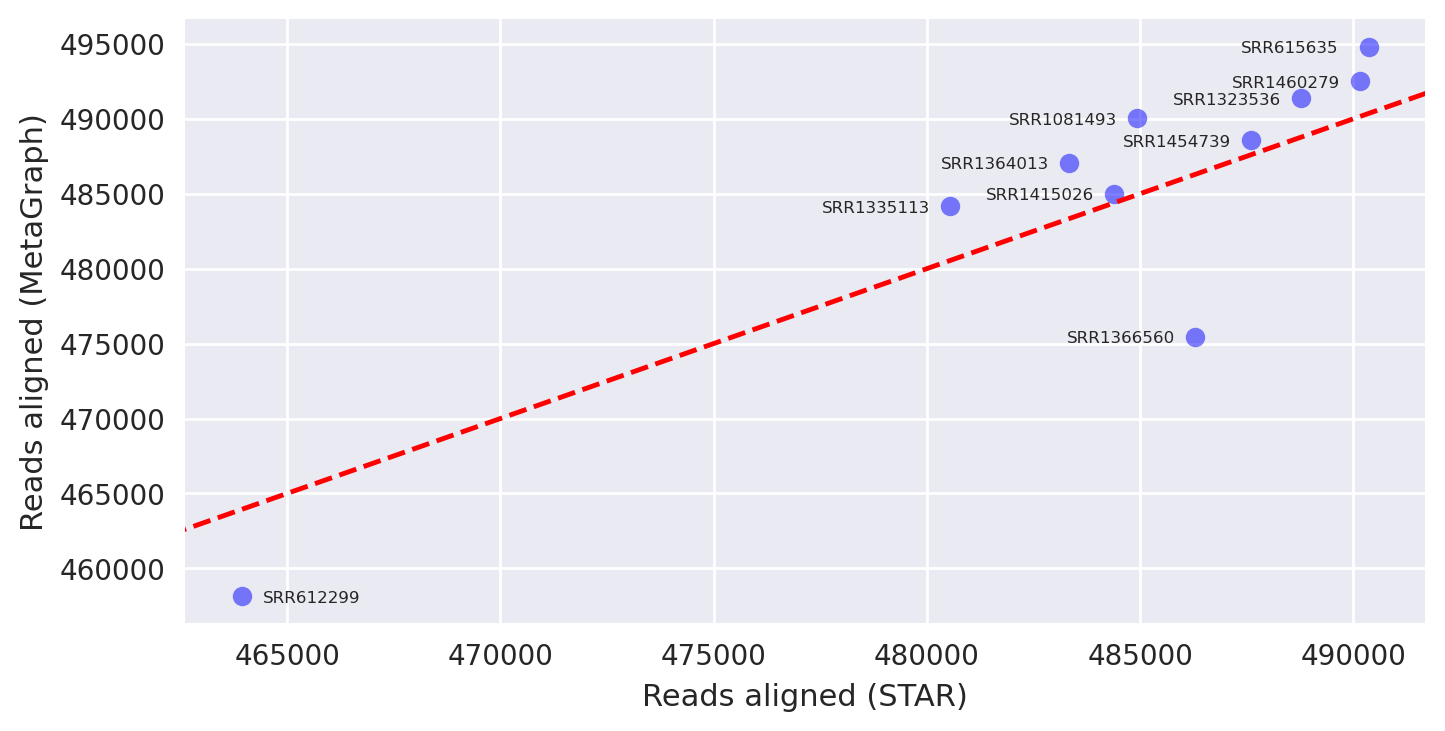

In [49]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(8, 4), dpi=200)
    ax = fig.add_subplot(111)
    x = df['star'].sum(1) - df['star'][76]
    y = df['meta_align'].sum(1) - df['meta_align'][76]
    ax.plot(x, y, 'bo', alpha=0.5)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    t = max(ylim[1], xlim[1])
    ax.plot([0, t], [0, t], 'r--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Reads aligned (STAR)')
    ax.set_ylabel('Reads aligned (MetaGraph)')
    for i, l in enumerate(df['star'].index):
        if x[i] < 470000:
            ax.annotate(l, (x[i] + 500, y[i] - 400), fontsize=6)
        else:
            ax.annotate(l, (x[i] - 3000, y[i] - 400), fontsize=6)
plt.savefig(os.path.join(plotdir, 'realigned_MGalign_vs_STAR.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(plotdir, 'realigned_MGalign_vs_STAR.pdf'), format='pdf', bbox_inches='tight')

In [36]:
df['star'].index

Index(['SRR1081493', 'SRR1323536', 'SRR1335113', 'SRR1364013', 'SRR1366560',
       'SRR1415026', 'SRR1454739', 'SRR1460279', 'SRR612299', 'SRR615635'],
      dtype='object')

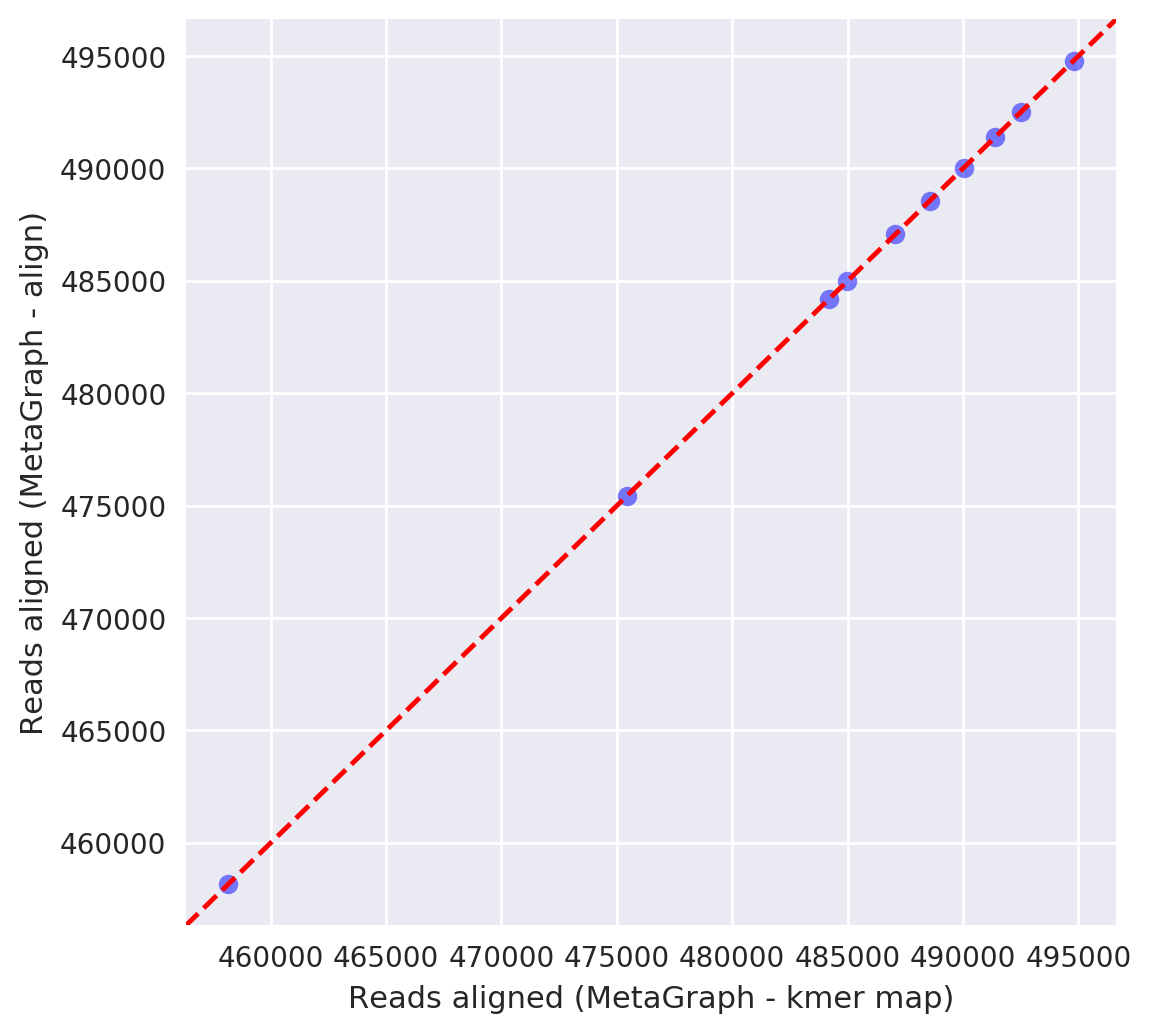

In [25]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(6, 6), dpi=200)
    ax = fig.add_subplot(111)
    ax.plot(df['meta_map'].sum(1) - df['meta_map'][76], df['meta_align'].sum(1) - df['meta_align'][76], 'bo', alpha=0.5)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    t = max(ylim[1], xlim[1])
    ax.plot([0, t], [0, t], 'r--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Reads aligned (MetaGraph - kmer map)')
    ax.set_ylabel('Reads aligned (MetaGraph - align)')
plt.savefig(os.path.join(plotdir, 'realigned_MGalign_vs_MGmap.png'), format='png', bbox_inches='tight')
plt.savefig(os.path.join(plotdir, 'realigned_MGalign_vs_MGmap.pdf'), format='pdf', bbox_inches='tight')

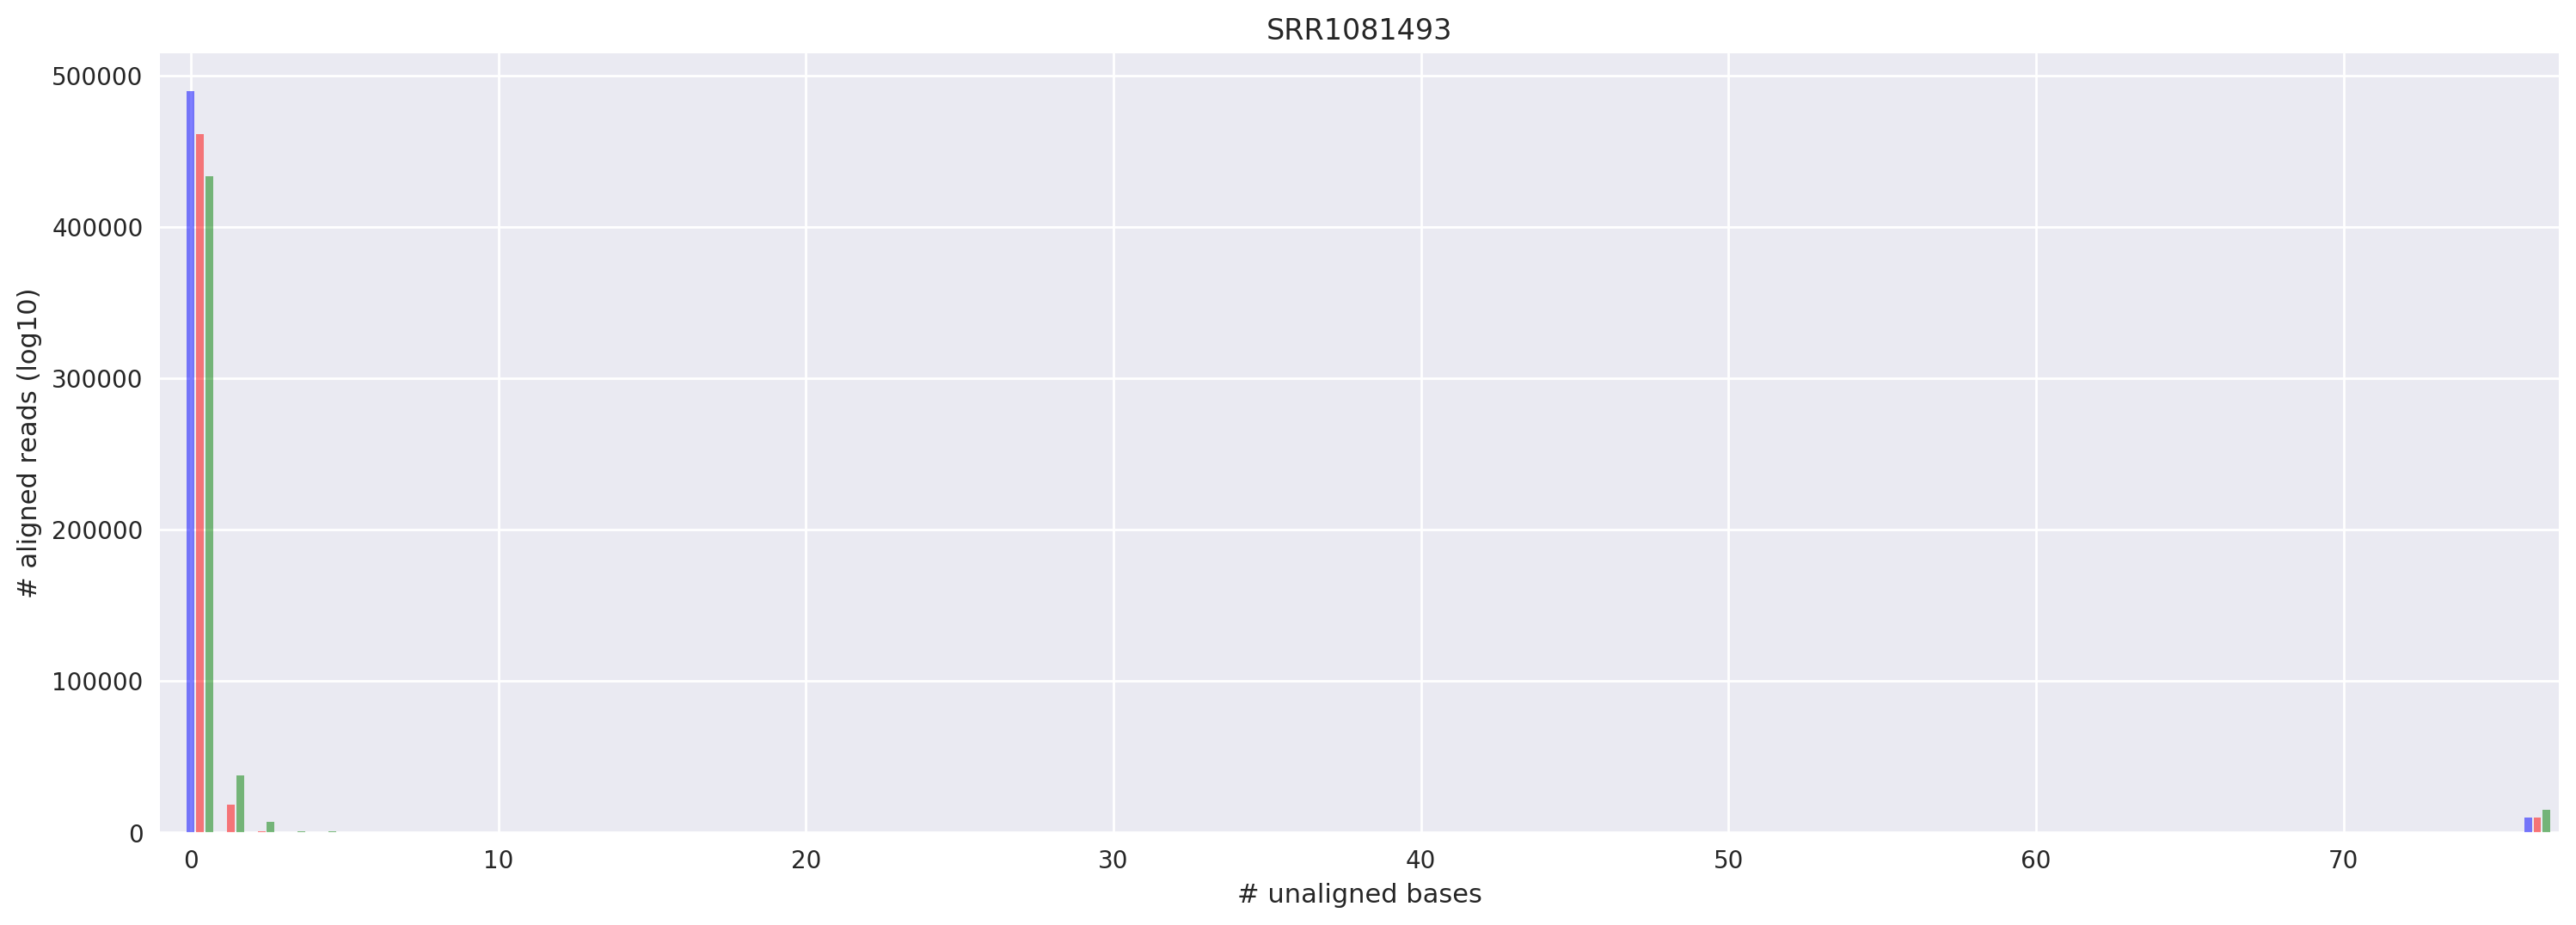

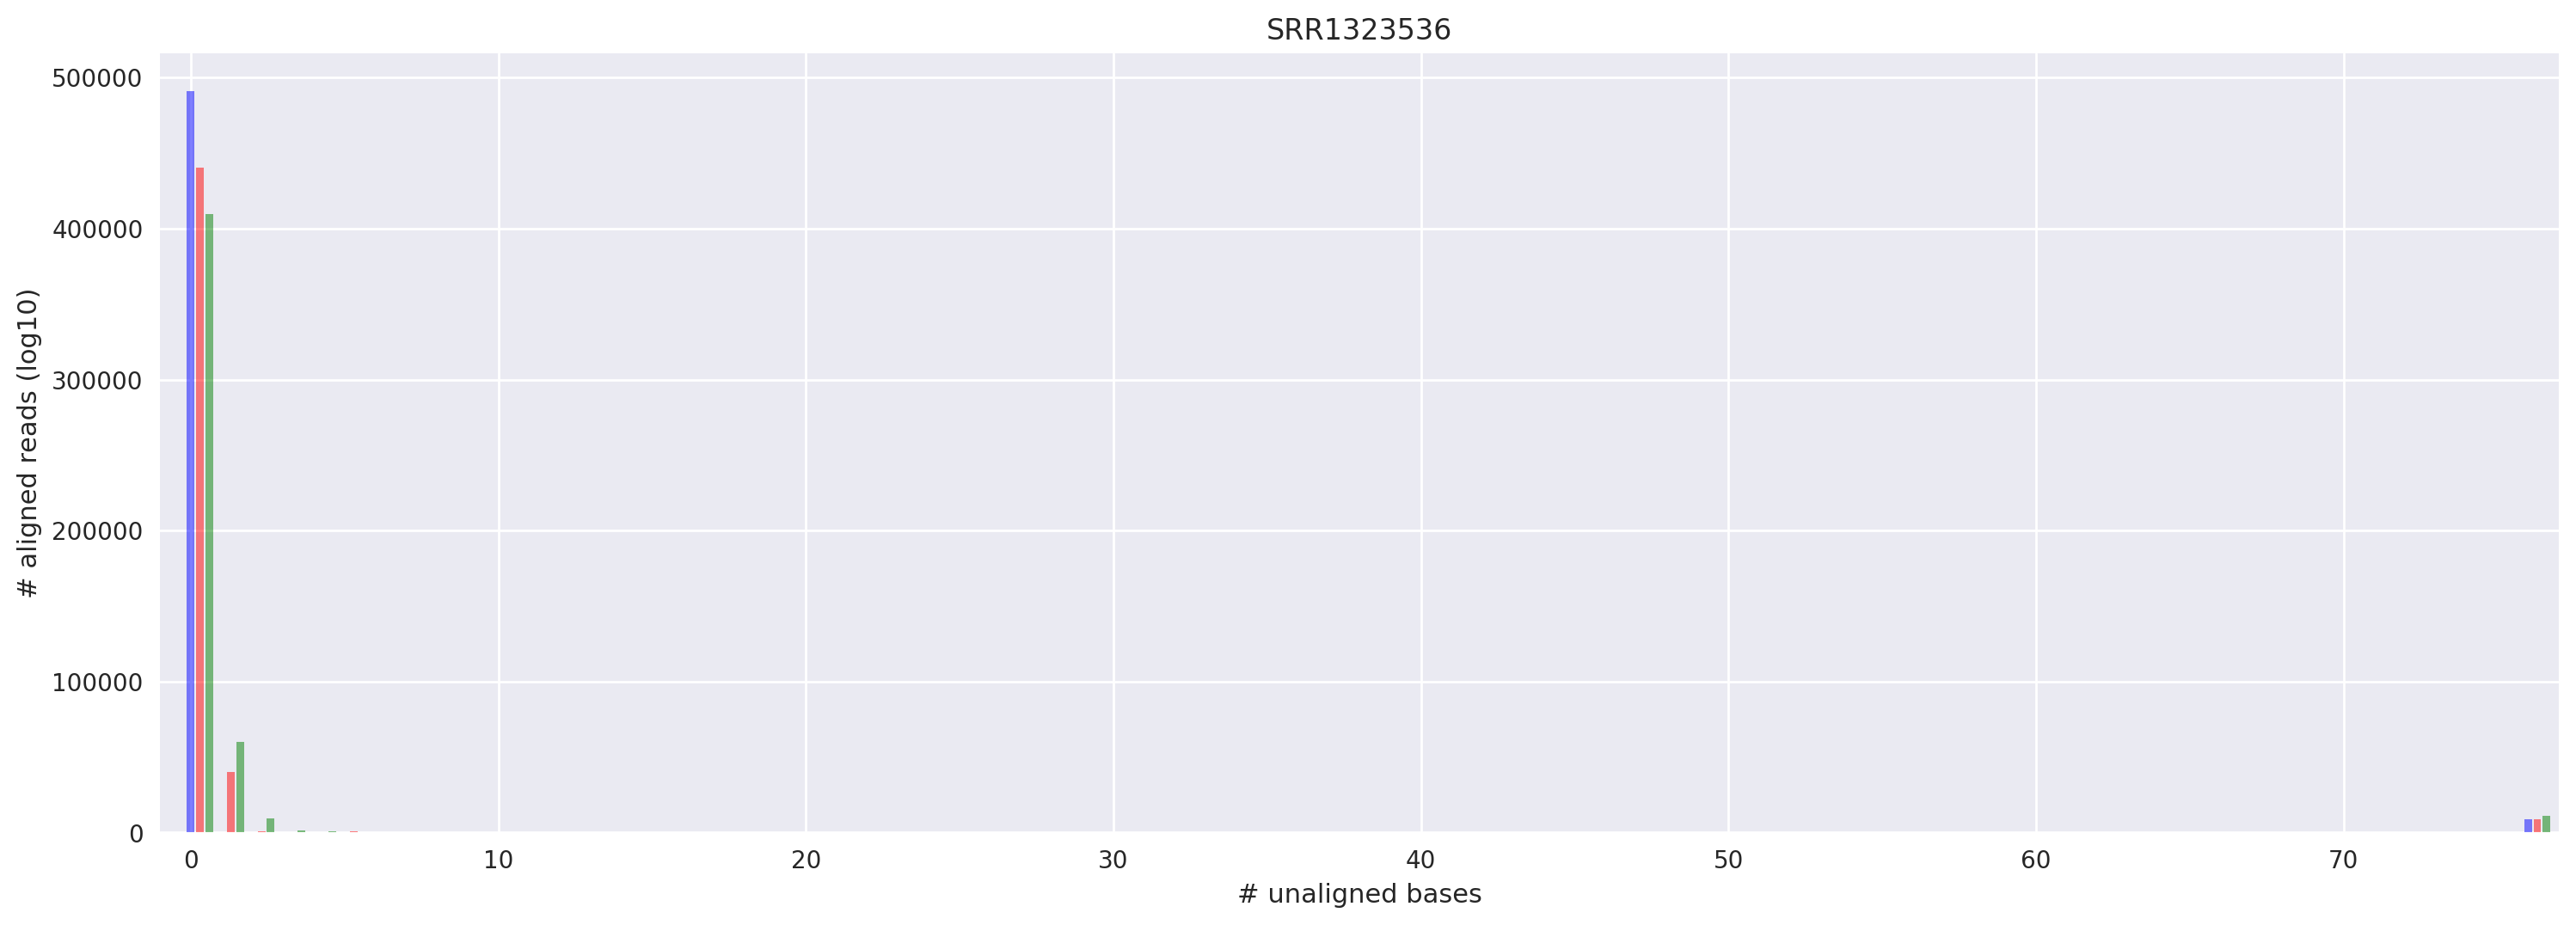

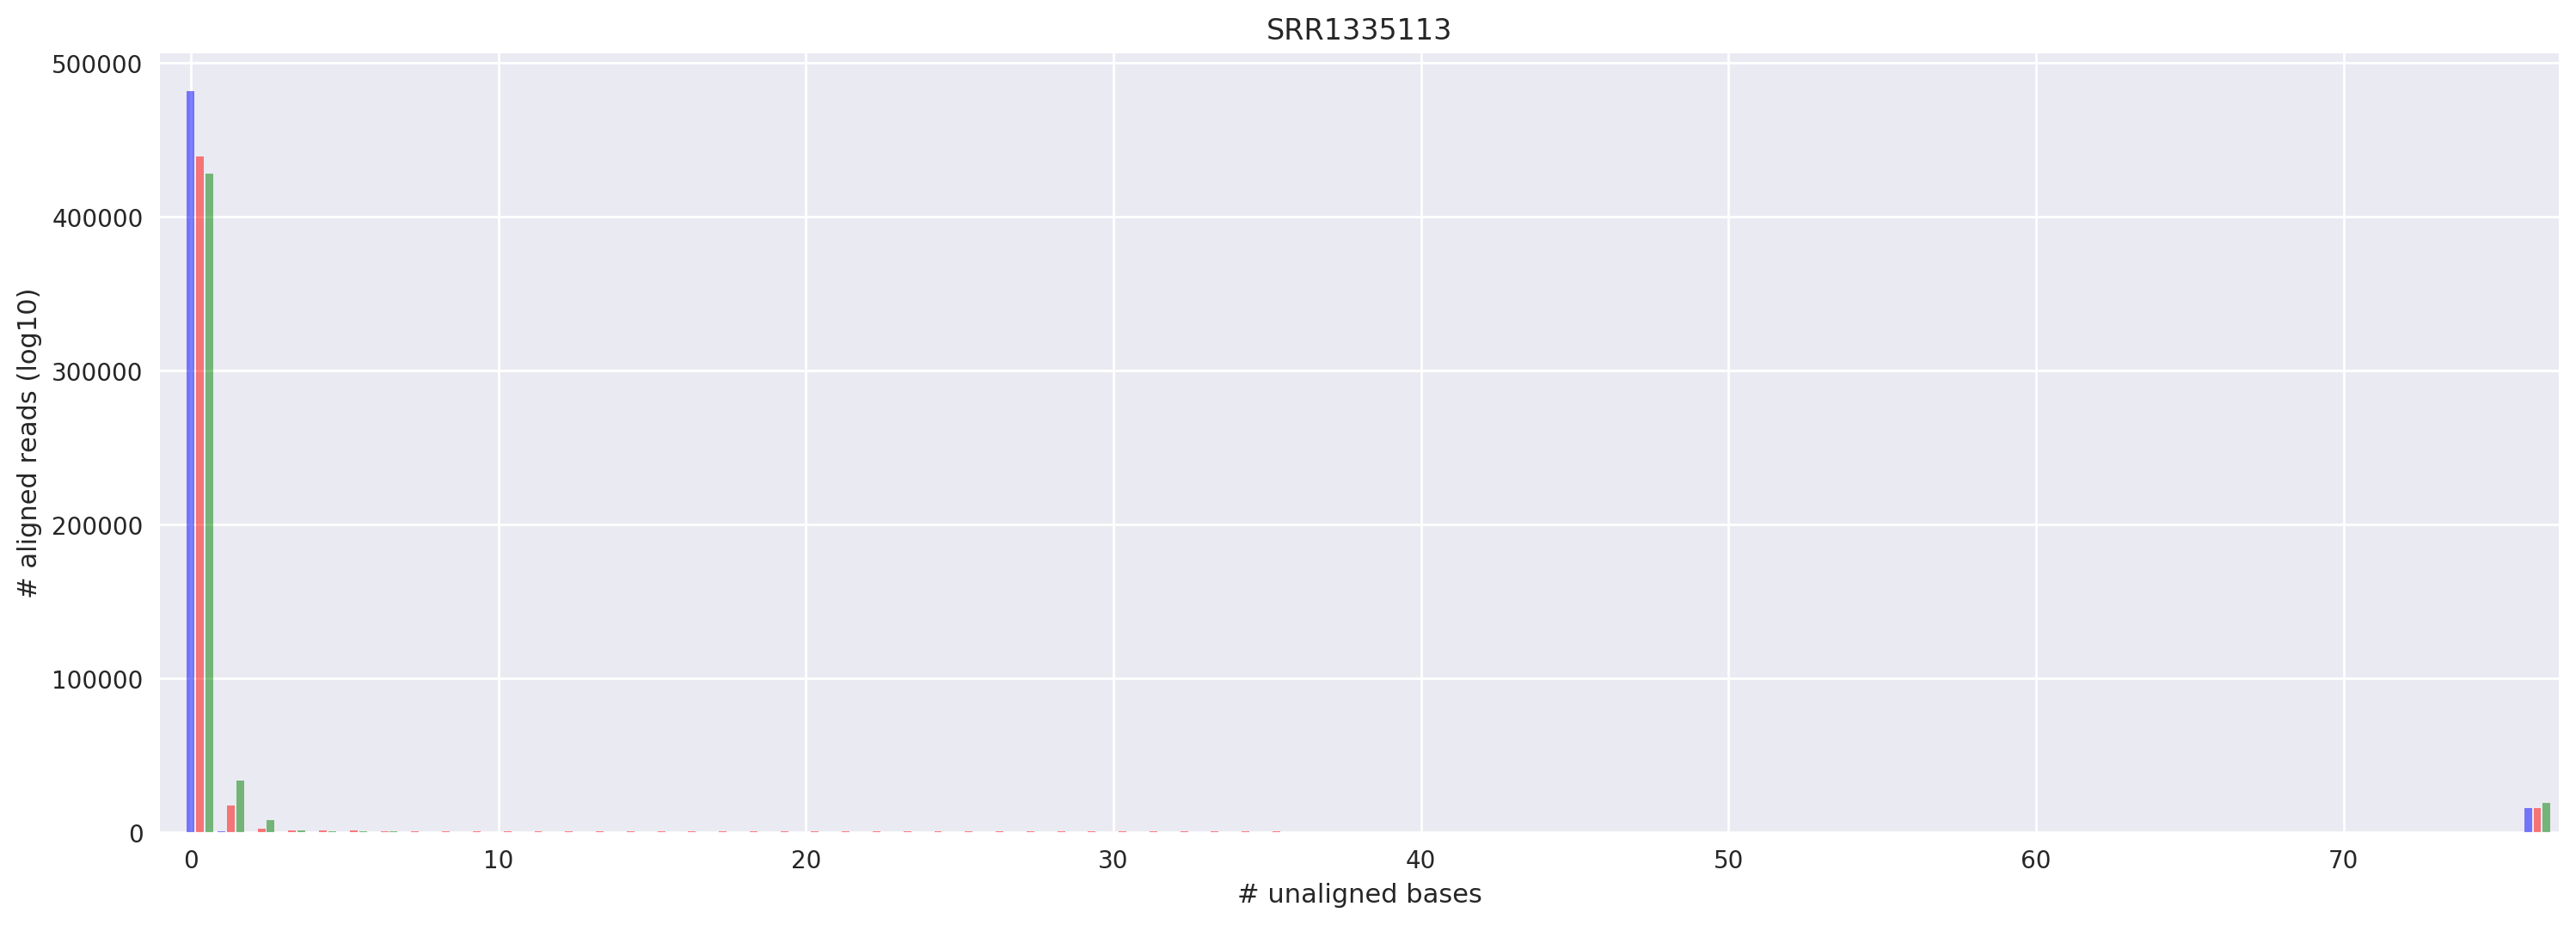

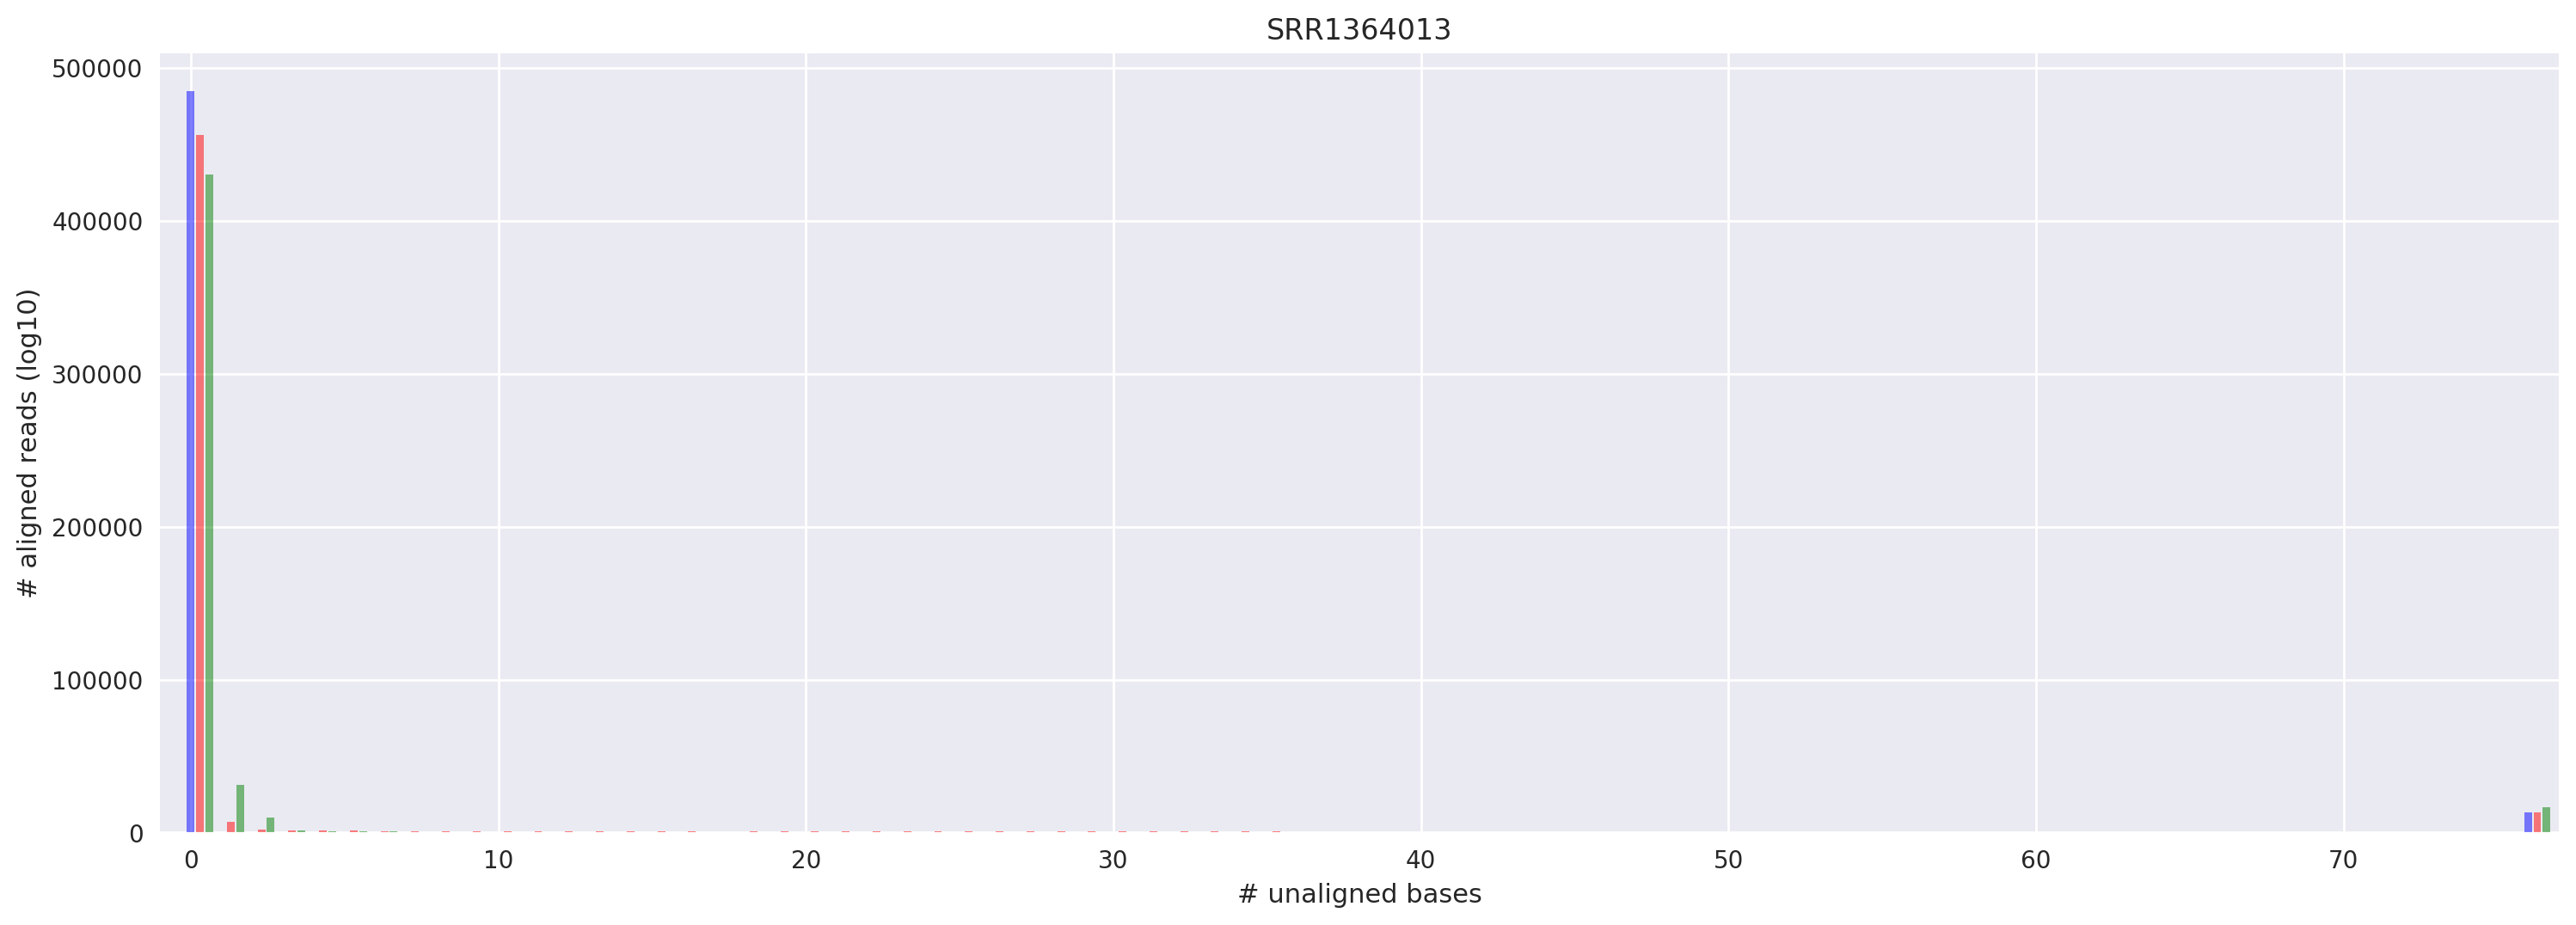

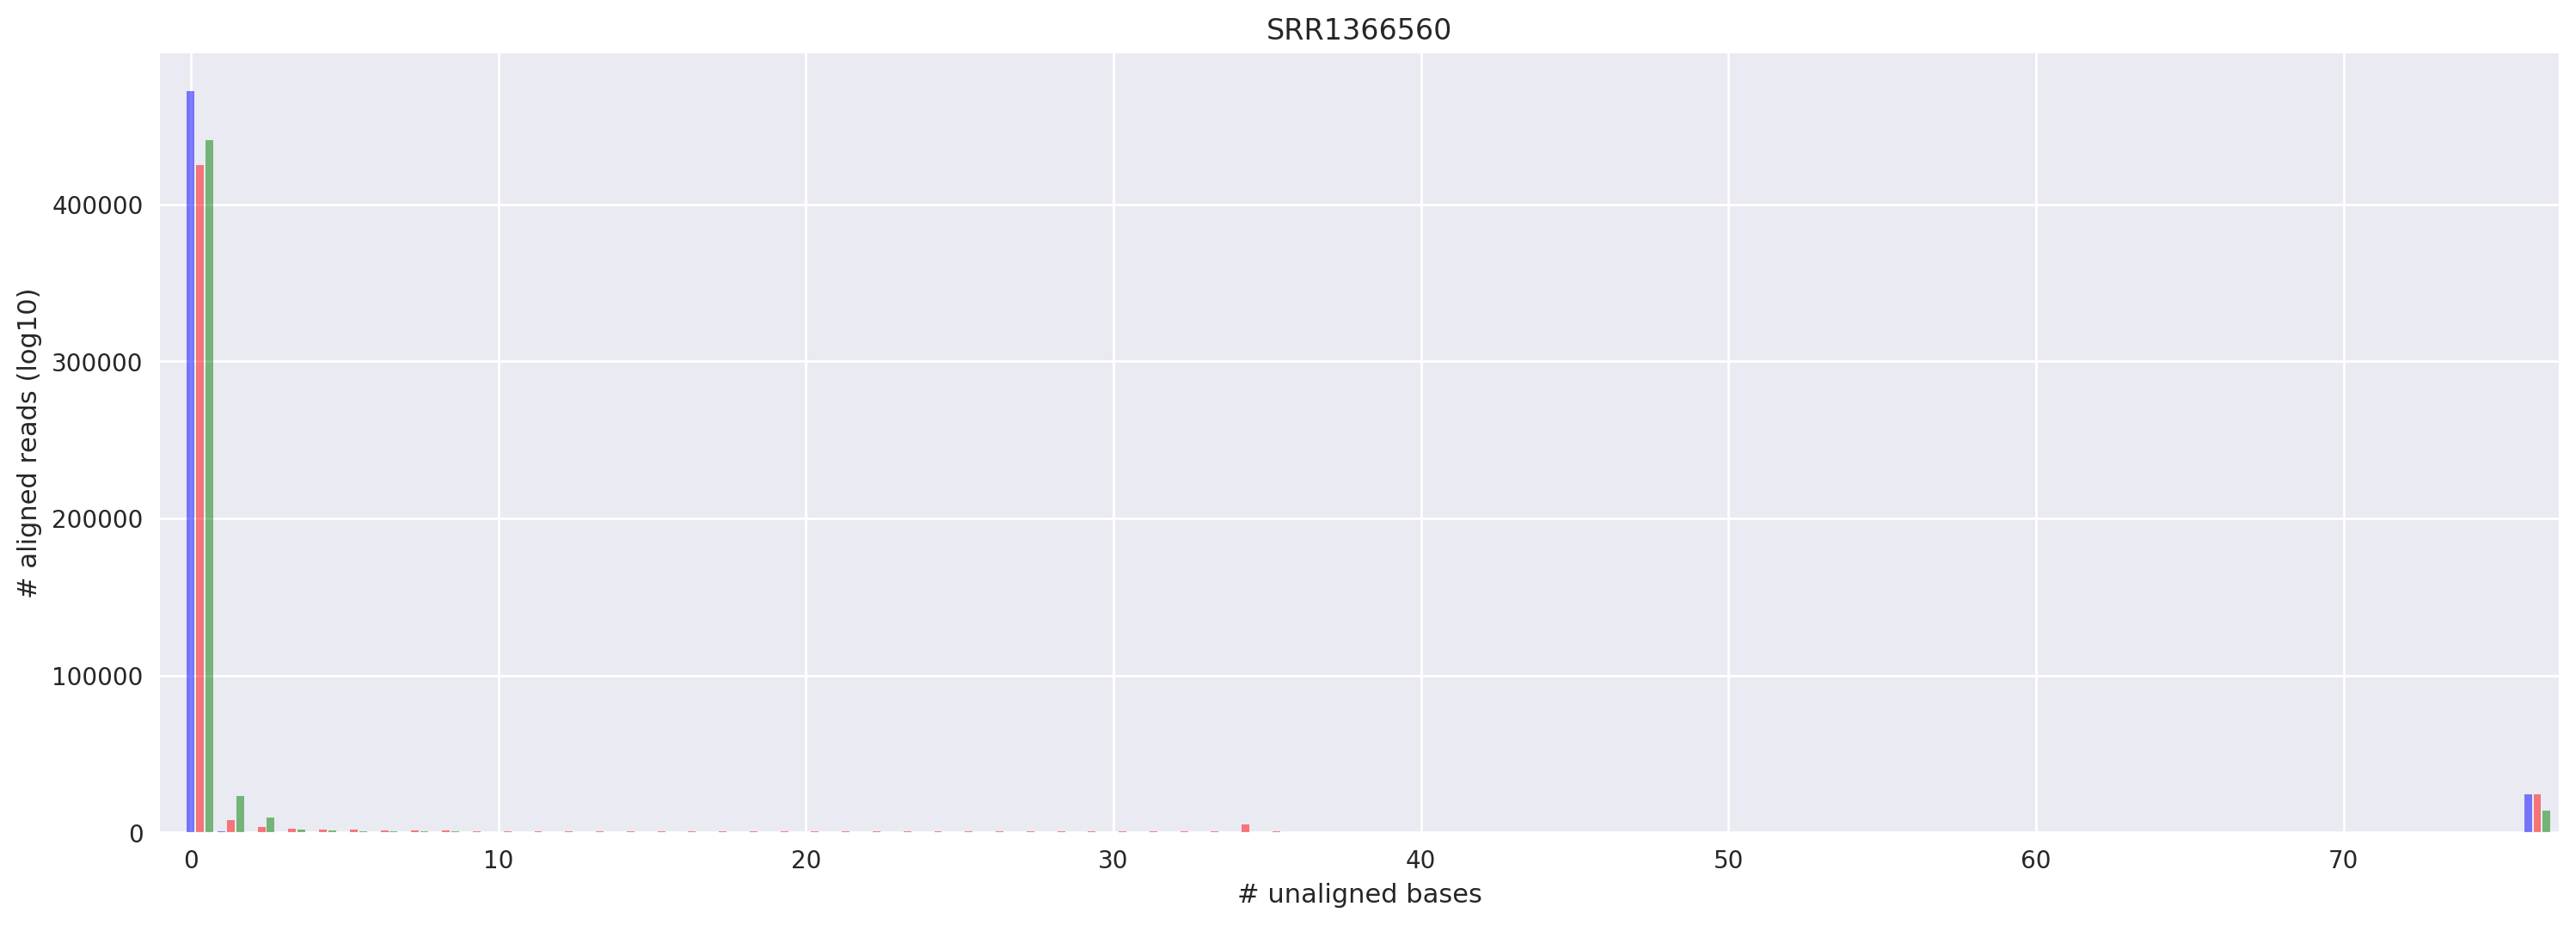

In [26]:
with plt.style.context('seaborn'):
    for idx in df['meta_align'].index[:5]:
        fig = plt.figure(figsize=(18, 6), dpi=200)
        ax = fig.add_subplot(111)
        #ax.bar(sp.arange(df['meta'].shape[1]), sp.log10(df['meta'].loc[idx] + 1), color='b', alpha=0.5)
        #ax.bar(sp.arange(df['star'].shape[1]), sp.log10(df['star'].loc[idx] + 1), color='r', alpha=0.5)
        ax.bar(sp.arange(df['meta_align'].shape[1]), df['meta_align'].loc[idx], width=0.25, color='b', alpha=0.5)
        ax.bar(sp.arange(df['meta_map'].shape[1]) + 0.3, df['meta_map'].loc[idx], color='r', width=0.25, alpha=0.5)
        ax.bar(sp.arange(df['star'].shape[1]) + 0.6, df['star'].loc[idx], color='g', width=0.25, alpha=0.5)
        ax.set_xlim([-1, 77])
        ax.set_xlabel('# unaligned bases')
        ax.set_ylabel('# aligned reads (log10)')
        ax.set_title(idx)